### 데이터 불러오기

In [86]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

In [87]:
# train, test 데이터를 불러옵니다.
path = '/Users/yniyunj/Desktop/AI/250115-EVpriceprediction'
train = pd.read_csv(path+'/open/train.csv')
test = pd.read_csv(path+'/open/test.csv')

In [88]:
# 한글 폰트 파일 경로 지정
font_path = "/Users/yniyunj/Library/Fonts/NanumGothic-Regular.ttf"  # 설치된 폰트 경로
font_prop = font_manager.FontProperties(fname=font_path)

# Matplotlib 설정
rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

print("현재 설정된 폰트:", plt.rcParams['font.family'])

현재 설정된 폰트: ['NanumGothic']


In [89]:
print(train.head(5))

           ID 제조사      모델        차량상태   배터리용량 구동방식  주행거리(km)  보증기간(년) 사고이력  \
0  TRAIN_0000  P사  TayGTS  Nearly New  86.077  AWD     13642        0   No   
1  TRAIN_0001  K사    Niro  Nearly New  56.000  FWD     10199        6   No   
2  TRAIN_0002  A사      eT   Brand New  91.200  AWD      2361        7   No   
3  TRAIN_0003  A사  RSeTGT  Nearly New     NaN  AWD     21683        3   No   
4  TRAIN_0004  B사      i5   Pre-Owned  61.018  AWD    178205        1   No   

   연식(년)  가격(백만원)  
0      2   159.66  
1      0    28.01  
2      0    66.27  
3      0    99.16  
4      0    62.02  


### Train 레이블 인코딩

In [90]:
from sklearn.preprocessing import LabelEncoder

encoded_train = train.copy()
# 범주형 열 확인
categorical_features = [col for col in encoded_train.columns if encoded_train[col].dtype == 'object']

# 레이블 인코딩 적용
for col in categorical_features:
    le = LabelEncoder()
    le.fit(encoded_train[col])
    encoded_train[col] = le.transform(encoded_train[col])
    
# 결과 확인
print(encoded_train.head())

   ID  제조사  모델  차량상태   배터리용량  구동방식  주행거리(km)  보증기간(년)  사고이력  연식(년)  가격(백만원)
0   0    4  16     1  86.077     0     13642        0     0      2   159.66
1   1    3  10     1  56.000     1     10199        6     0      0    28.01
2   2    0  17     0  91.200     0      2361        7     0      0    66.27
3   3    0  12     1     NaN     0     21683        3     0      0    99.16
4   4    1  19     2  61.018     0    178205        1     0      0    62.02


### Test 레이블 인코딩

In [91]:
encoded_test = test.copy()
# 범주형 열 확인
categorical_features = [col for col in encoded_test.columns if encoded_test[col].dtype == 'object']

# 레이블 인코딩 적용
for col in categorical_features:
    le = LabelEncoder()
    le.fit(encoded_test[col])
    encoded_test[col] = le.transform(encoded_test[col])
    
# 결과 확인
print(encoded_test.head())

   ID  제조사  모델  차량상태   배터리용량  구동방식  주행거리(km)  보증기간(년)  사고이력  연식(년)
0   0    4  15     1  76.093     0     14057        2     0      0
1   1    1  20     0  90.000     0      7547        8     0      0
2   2    1  19     0     NaN     2      7197        7     1      0
3   3    2   2     1  68.479     0     10357        7     0      1
4   4    3   0     0     NaN     1      7597       10     0      0


### 상관계수 분석

- 차량상태(-0.79), 주행거리(-0.58), 보증기간(0.56), 가격(0.43)
- 가격은 제외(train과 test에서 동일한 데이터 분포와 처리방식을 유지해야 일반화 성능이 더 안정적임)

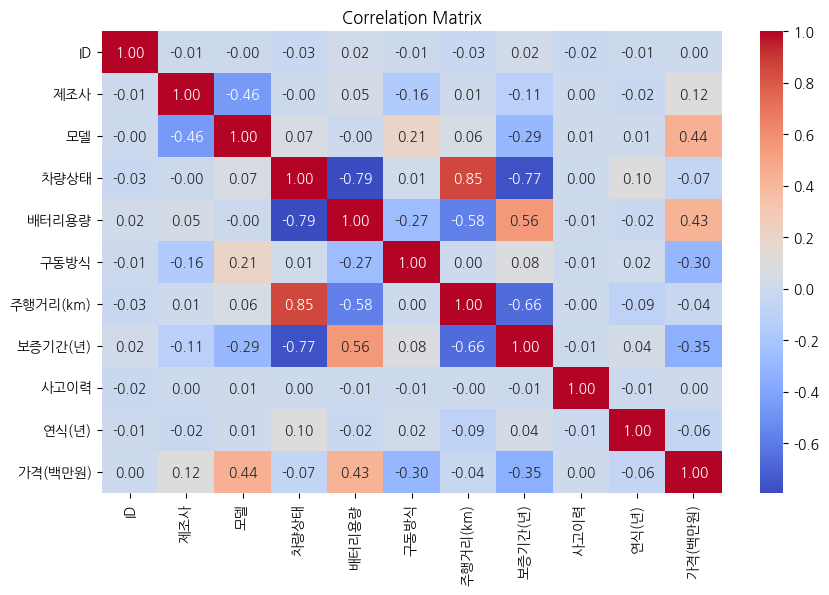

In [92]:
# 상관계수 계산
correlation_matrix = encoded_train.corr()

# 상관계수 히트맵 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

### Train 배터리 용량 결측값 채우기 (회귀모델 훈련)

- 배터리 용량을 목표 변수로 설정하고, 나머지 변수를 입력 변수로 사용해 회귀 모델을 훈련하여 결측치를 예측함
- KNN, RandomForest, LightGBM, XGBoost, CatBoost 모델 비교

In [93]:
# 결측값이 없는 데이터와 결측값이 있는 데이터 분리
train_data_no_na = encoded_train.dropna(subset=['배터리용량']).copy()
train_data_with_na = encoded_train[encoded_train['배터리용량'].isnull()].copy()


# 사용 변수 선택
features = ['보증기간(년)', '주행거리(km)', '차량상태']

# 결측값이 없는 데이터 준비
X = train_data_no_na[features]
y = train_data_no_na['배터리용량']

# 결측값이 있는 데이터 준비
X_missing = train_data_with_na[features]

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

KNN RMSE: 8.735244437717848
RandomForest RMSE: 8.98240966533893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 3828, number of used features: 3
[LightGBM] [Info] Start training from score 69.381099
LightGBM RMSE: 7.751383436420195
XGBoost RMSE: 8.159720480445705
CatBoost RMSE: 7.77405537845468


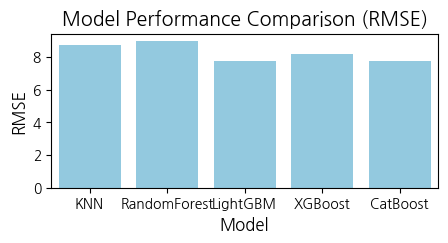

In [94]:
# 모델 리스트
models = {
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "RandomForest": RandomForestRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0)
}

# 결과 저장
model_performance = {}

# 모델 비교
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)  # RMSE 계산
    model_performance[name] = rmse
    print(f"{name} RMSE: {rmse}")

# 시각화
plt.figure(figsize=(5, 2))
sns.barplot(x=list(model_performance.keys()), y=list(model_performance.values()), color='skyblue')
plt.title("Model Performance Comparison (RMSE)", fontsize=14)
plt.ylabel("RMSE", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.show()

In [95]:
# 회귀 모델 초기화 및 훈련
model = LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

# 검증 데이터로 모델 평가
y_pred = model.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"검증 데이터 RMSE: {rmse}")

# 결측값 예측
train_data_with_na.loc[:, '배터리용량'] = model.predict(X_missing)

# 결측값이 채워진 데이터 결합
train_data_filled = pd.concat([train_data_no_na, train_data_with_na])

# 공백을 밑줄로 대체
train_data_filled.columns = train_data_filled.columns.str.replace(" ", "-")

# 채워진 데이터 저장
train_data_filled.to_csv(path+'/open/240116-encoded_train_filled.csv', index=False)

train_data_filled.info()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 3828, number of used features: 3
[LightGBM] [Info] Start training from score 69.381099
검증 데이터 RMSE: 7.751383436420195
<class 'pandas.core.frame.DataFrame'>
Index: 7497 entries, 0 to 7494
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   int64  
 1   제조사       7497 non-null   int64  
 2   모델        7497 non-null   int64  
 3   차량상태      7497 non-null   int64  
 4   배터리용량     7497 non-null   float64
 5   구동방식      7497 non-null   int64  
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   int64  
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
dtypes: float64(2), 

###  결측값이 채워진 배터리용량 데이터의 분포를 기존 데이터와 비교

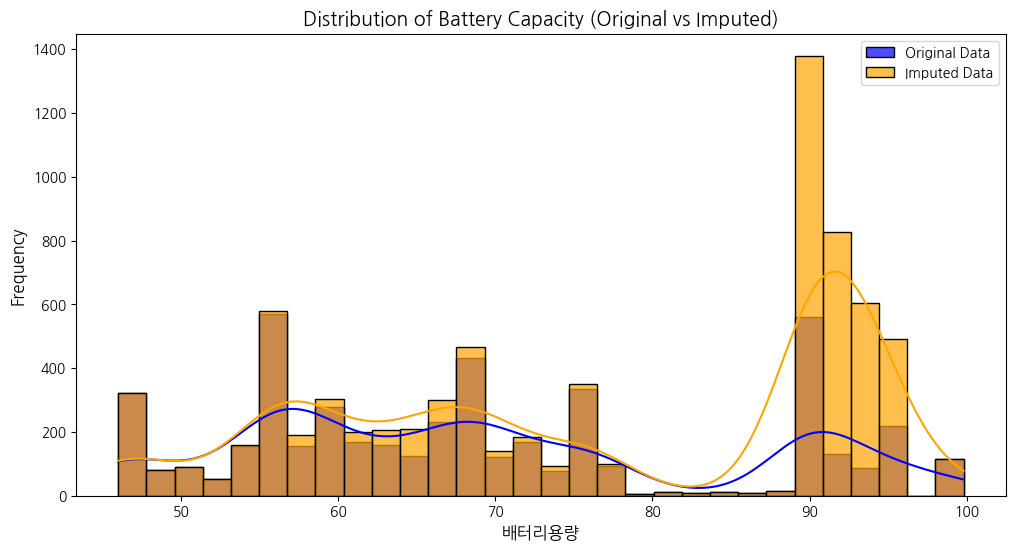

In [96]:
# 결측값이 없었던 데이터와 결측값이 채워진 데이터 분리
original_data = encoded_train[~encoded_train['배터리용량'].isnull()]  # 원래 결측값이 없었던 데이터
imputed_data = train_data_filled[~train_data_filled['배터리용량'].isnull()] # 결측값이 채워진 데이터

# 히스토그램 비교
plt.figure(figsize=(12, 6))

# 원본 데이터 히스토그램
sns.histplot(original_data['배터리용량'], bins=30, kde=True, color='blue', label='Original Data', alpha=0.7)

# 결측값 채워진 데이터 히스토그램
sns.histplot(imputed_data['배터리용량'], bins=30, kde=True, color='orange', label='Imputed Data', alpha=0.7)

plt.title('Distribution of Battery Capacity (Original vs Imputed)', fontsize=14)
plt.xlabel('배터리용량', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

### Test 배터리 용량 결측값 채우기 (회귀모델 훈련)

In [97]:
# 사용 변수 선택 (훈련 데이터와 동일)
features = ['보증기간(년)', '주행거리(km)', '차량상태']

# 결측값이 있는 데이터 준비
test_data_with_na = encoded_test[encoded_test['배터리용량'].isnull()].copy()
X_missing_test = test_data_with_na[features]
X_missing_test = X_missing_test.reindex(columns=X_train.columns, fill_value=0)

# 모델을 사용해 배터리용량 결측값 예측
test_data_with_na.loc[:, '배터리용량'] = model.predict(X_missing_test)

# 배터리용량이 채워진 데이터 결합
test_data_filled = pd.concat([encoded_test.dropna(subset=['배터리용량']), test_data_with_na])

# 채워진 데이터 저장
test_data_filled.to_csv(path + '/open/240116-encoded_test_filled.csv', index=False)

test_data_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 846 entries, 0 to 838
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        846 non-null    int64  
 1   제조사       846 non-null    int64  
 2   모델        846 non-null    int64  
 3   차량상태      846 non-null    int64  
 4   배터리용량     846 non-null    float64
 5   구동방식      846 non-null    int64  
 6   주행거리(km)  846 non-null    int64  
 7   보증기간(년)   846 non-null    int64  
 8   사고이력      846 non-null    int64  
 9   연식(년)     846 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 72.7 KB


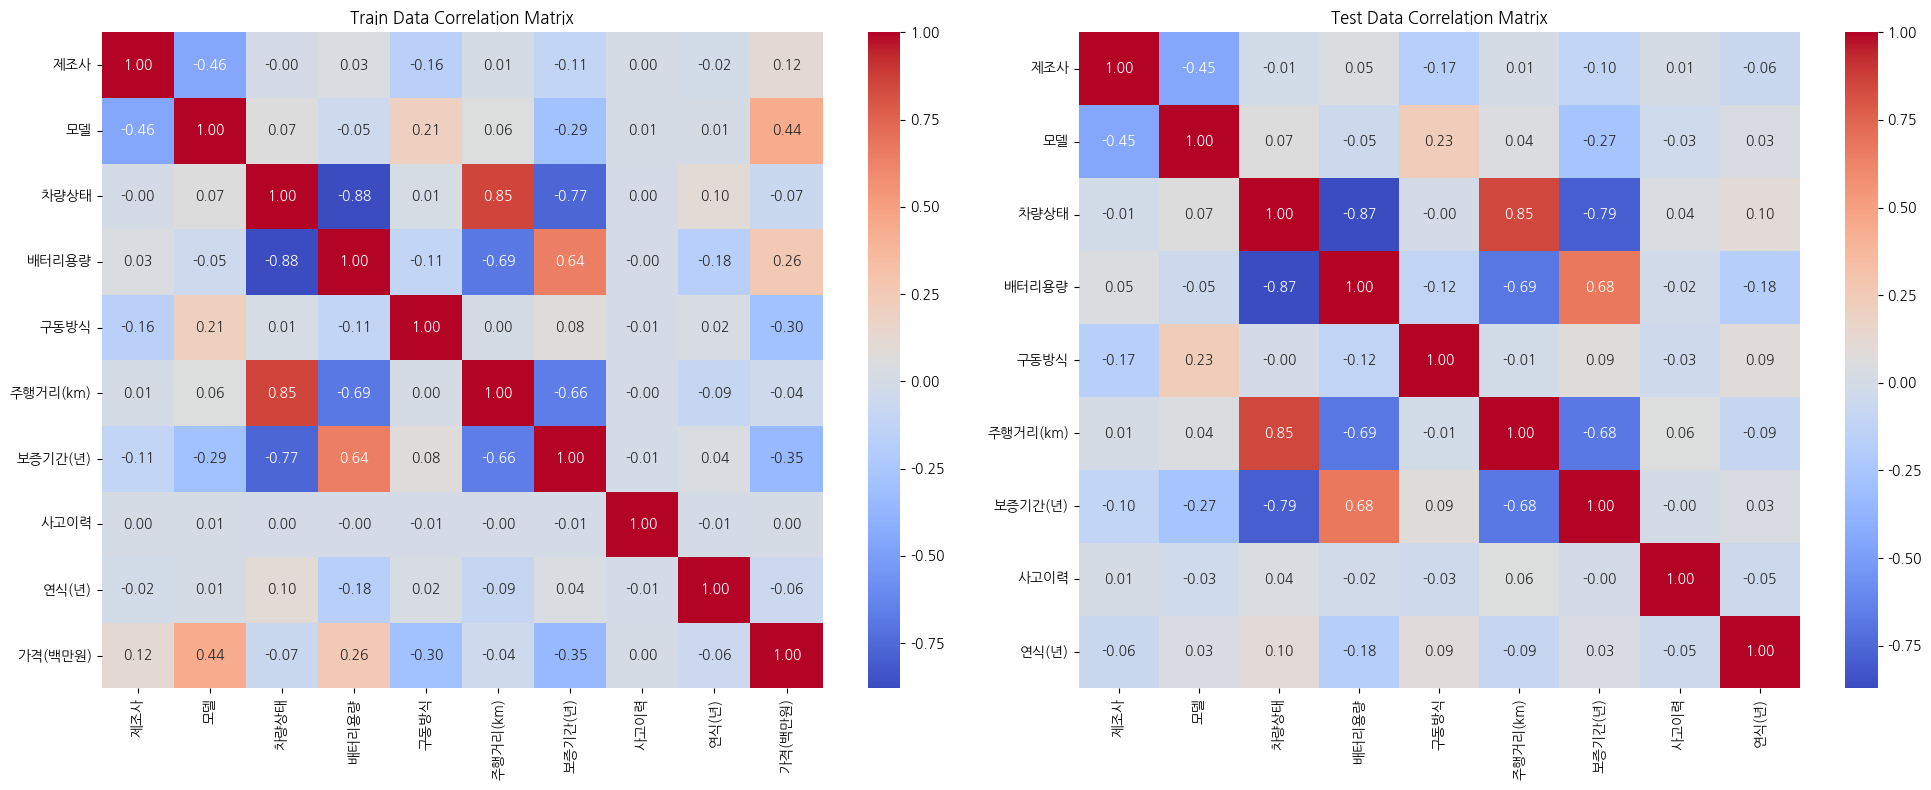

In [102]:
# train_data_filled와 test_data_filled 데이터셋의 상관계수 행렬 계산
train_correlation_matrix = train_data_filled.drop('ID', axis=1).corr()
test_correlation_matrix = test_data_filled.drop('ID', axis=1).corr()

# side-by-side plot 설정
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Train 데이터 상관계수 히트맵
sns.heatmap(train_correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, ax=axes[0])
axes[0].set_title("Train Data Correlation Matrix")

# Test 데이터 상관계수 히트맵
sns.heatmap(test_correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, ax=axes[1])
axes[1].set_title("Test Data Correlation Matrix")

# 레이아웃 정리 및 표시
plt.tight_layout()
plt.show()

### 학습 & 예측

In [103]:
# 학습과 예측을 위해 데이터를 분리합니다.
x_train = train_data_filled.drop(['ID', '가격(백만원)'], axis = 1)
y_train = train_data_filled['가격(백만원)']

x_test = test_data_filled.drop('ID', axis = 1)

In [105]:
# 모델을 선언하고, 학습을 진행합니다.
model = DecisionTreeRegressor()
model.fit(x_train, y_train)

DecisionTreeRegressor()

In [106]:
# 예측을 수행합니다.
pred = model.predict(x_test)

### 제출하기

In [108]:
# sample_submission 파일을 불러옵니다.
submit = pd.read_csv(path+'/open/sample_submission.csv')

# 예측한 결과를 submit에 저장합니다.
submit['가격(백만원)'] = pred
submit.head()

,ID,가격(백만원)
0,TEST_000,130.84
1,TEST_001,80.26
2,TEST_002,34.21
3,TEST_003,80.98
4,TEST_004,23.72


In [109]:
# 제출을 위해 baseline_submission.csv란 이름으로 CSV 파일을 저장합니다.
submit.to_csv(path+'/submission/240116-pred05.csv',index=False)